# Carga de datos

Este tutorial es una selección y adaptación al español del libro [Natural Language Processing with Python – Analyzing Text with the Natural Language Toolkit](https://www.nltk.org/book/).

La fuente de textos más importante es sin duda la Web. Es conveniente tener colecciones de texto existentes para explorar. Sin embargo, probablemente tengas en mente tus propias fuentes de texto y necesites aprender a acceder a ellas.

El objetivo de este capítulo es responder la siguiente pregunta:

¿Cómo podemos escribir programas para acceder a texto desde archivos locales y desde la web, con el fin de disponer de una variedad ilimitada de material lingüístico?

In [2]:
import nltk, re, pprint
from unicodedata import normalize
from bs4 import BeautifulSoup

nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/renato/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/renato/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Acceso a texto desde la web y desde el disco

### Libros electrónicos

Puede que te interese analizar textos del Proyecto Gutenberg. Puede explorar el catálogo de 25.000 libros en línea gratuitos en http://www.gutenberg.org/catalog/ y obtener una URL a un archivo de texto ASCII. Aunque el 90% de los textos del Proyecto Gutenberg están en inglés, incluye material en más de 50 idiomas, entre ellos catalán, chino, holandés, finlandés, francés, alemán, italiano, portugués y español (con más de 100 textos cada uno).

El número de texto 21282 es Tradiciones Peruanas, y podemos acceder a él de la siguiente manera:

In [3]:
from urllib.request import urlopen

url = "https://www.gutenberg.org/files/21282/21282-8.txt"
raw = urlopen(url).read().decode("ISO-8859-1")
print(type(raw))
print(len(raw))
print(raw[:69])

<class 'str'>
305617
The Project Gutenberg EBook of Tradiciones peruanas, by Ricardo Palma


La variable `raw` contiene una cadena con 305 617 caracteres. Este es el contenido sin procesar del libro, incluyendo muchos detalles que no nos interesan, como espacios en blanco, saltos de línea y líneas en blanco. Observe \r y \n en la línea de apertura del archivo, que es cómo Python muestra el retorno de carro especial y los caracteres de avance de línea (el archivo debe haber sido creado en una máquina con Windows). Para nuestro procesamiento de lenguaje, queremos dividir la cadena en palabras y puntuación. Este paso se llama **tokenización** y produce nuestra estructura familiar, una lista de palabras y puntuación.

In [4]:
tokens = nltk.word_tokenize(raw, language="spanish")
print(type(tokens))
print(len(tokens))
print(tokens[:10])

<class 'list'>
58057
['The', 'Project', 'Gutenberg', 'EBook', 'of', 'Tradiciones', 'peruanas', ',', 'by', 'Ricardo']


Ten en cuenta que se necesitaba NLTK para la tokenización, pero no para ninguna de las tareas anteriores de abrir una URL y leerla en una cadena. Si ahora damos el paso adicional de crear un texto NLTK a partir de esta lista, podemos llevar a cabo otros aspectos de procesamiento lingüístico:

In [5]:
text = nltk.Text(tokens)
print(type(text))
print(text[800:950])

<class 'nltk.text.Text'>
['lejos', 'de', 'pensar', 'en', 'defender', 'como', 'bravos', 'sus', 'hogares', ',', 'invocaban', 'la', 'protección', 'divina', 'contra', 'los', 'herejes', 'holandeses', '.', 'El', 'anciano', 'y', 'corajudo', 'virrey', 'disponía', 'escasamente', 'de', 'mil', 'hombres', 'en', 'el', 'Callao', ',', 'y', 'nótese', 'que', ',', 'según', 'el', 'censo', 'de', '1614', ',', 'el', 'número', 'de', 'habitantes', 'de', 'Lima', 'ascendía', 'a', '25.454', '.', 'Pero', 'Spitberg', 'se', 'conformó', 'con', 'disparar', 'algunos', 'cañonazos', 'que', 'le', 'fueron', 'débilmente', 'contestados', ',', 'e', 'hizo', 'rumbo', 'para', 'Paita', '.', 'Peralta', 'en', 'su', '_Lima', 'fundada_', ',', 'y', 'el', 'conde', 'de', 'la', 'Granja', ',', 'en', 'su', 'poema', 'de', '_Santa', 'Rosa_', ',', 'traen', 'detalles', 'sobre', 'esos', 'luctuosos', 'días', '.', 'El', 'sentimiento', 'cristiano', 'atribuye', 'la', 'retirada', 'de', 'los', 'piratas', 'a', 'milagro', 'que', 'realizó', 'la', 'virg

In [6]:
text.collocations()

Project Gutenberg-tm; Project Gutenberg; Literary Archive; Gutenberg-
tm electronic; electronic works; Archive Foundation; mil pesos;
Gutenberg Literary; del Perú; United States; excelentísimo señor;
ÉPOCA DEL; set forth; fray Venancio; public domain; estos reinos;
electronic work; Buenos Aires; vuesa merced; Carlos III


Observa que el Proyecto Gutenberg aparece como una colocación. Esto se debe a que cada texto descargado del Proyecto Gutenberg contiene un encabezado con el nombre del texto, el autor, los nombres de las personas que escanearon y corrigieron el texto, una licencia, etc. A veces, esta información aparece en un pie de página al final del archivo. No podemos detectar de manera confiable dónde comienza y termina el contenido, por lo que tenemos que recurrir a la inspección manual del archivo, para descubrir cadenas únicas que marcan el comienzo y el final, antes de recortar en bruto para que sea solo el contenido y nada más:

In [7]:
print(raw.find("LOS DUENDES DEL CUZCO"))
print(
    raw.rfind(
        "End of the Project Gutenberg EBook of Tradiciones peruanas, by Ricardo Palma"
    )
)

1500
286409


In [8]:
raw = raw[1500:286409]
raw.find("LOS DUENDES DEL CUZCO")

0

Los métodos `find()` y `rfind()` ("búsqueda inversa") nos ayudan a obtener los valores de índice correctos para usar para cortar la cadena. Sobrescribimos sin formato con este segmento, por lo que ahora comienza con "PARTE I" y sube hasta (pero sin incluir) la frase que marca el final del contenido.

Este fue nuestro primer contacto con la realidad de la web: los textos que se encuentran en la web pueden contener material no deseado y es posible que no exista una forma automática de eliminarlo. Pero con un poco de trabajo extra podemos extraer el material que necesitamos.

### Lidiando con HTML

Gran parte del texto de la web está en forma de documentos HTML. Puede usar un navegador web para guardar una página como texto en un archivo local y luego acceder a esto como se describe en la sección de archivos. Sin embargo, si va a hacer esto con frecuencia, es más fácil conseguir que Python haga el trabajo directamente. El primer paso es el mismo que antes, usando urlopen. 

Para ilustrar, seleccionaremos un artículo de El País llamado “La neurociencia no tiene la receta para los problemas de la educación”:

In [9]:
url = (
    "https://elpais.com/economia/2018/02/16/actualidad/1518783405_526230.html"
)
html = urlopen(url).read()
html[:60]

b'<!DOCTYPE html><html lang="es"><head><link rel="preconnect" '

Puede escribir `print(html)` para ver el contenido HTML en todo su esplendor, incluidas las metaetiquetas, un mapa de imágenes, JavaScript, formularios y tablas.

Obtener texto de HTML es una tarea común y la librería BeautifulSoup ofrece una solución a través de la función `get_text()`, que toma una cadena HTML y devuelve texto sin formato.

In [10]:
soup = BeautifulSoup(html, "html.parser")
raw = soup.get_text()

Luego podemos tokenizar esto para obtener nuestra estructura de texto familiar:

In [11]:
tokens = nltk.word_tokenize(raw, language="spanish")
print(tokens)

['Anna', 'Carballo', ':', '“', 'La', 'neurociencia', 'no', 'tiene', 'la', 'receta', 'para', 'los', 'problemas', 'de', 'la', 'educación', '”', '|', 'Formación', '|', 'Economía', '|', 'EL', 'PAÍS', 'Seleccione', ':', '-', '-', '-EspañaAméricaMéxicoColombiaChileArgentinaUSAFormaciónsuscríbeteHHOLAIniciar', 'sesiónOfrecido', 'porEmagisterFormaciónFormaciónAvance', 'Consulte', 'la', 'portada', 'de', 'EL', 'PAÍS', ',', 'Edición', 'Nacional', ',', 'del', '23', 'de', 'mayoFORMACIÓN', '“', 'La', 'neurociencia', 'no', 'tiene', 'la', 'receta', 'para', 'los', 'problemas', 'de', 'la', 'educación', '”', 'La', 'neurocientífica', 'Anna', 'Carballo', 'cree', 'que', 'son', 'los', 'pedagogos', 'los', 'que', 'deben', 'resolver', 'los', 'retos', 'del', 'sistema', 'educativo', 'y', 'reducir', 'la', 'tasa', 'de', 'abandono', 'escolarAna', 'Torres', 'Menárguez19', 'feb', '2018', '-', '07:22', 'UTCWhatsappFacebookTwitterCopiar', 'enlaceComentariosAnna', 'Carballo', '(', 'Barcelona', ',', '1982', ')', ',', 'doc

Esto todavía contiene material no deseado sobre la navegación del sitio y las historias relacionadas. Con un poco de prueba y error, puede encontrar los índices de inicio y finalización del contenido y seleccionar los tokens de interés e inicializar un texto como en el caso anterior.

In [12]:
tokens = tokens[101:2097]
text = nltk.Text(tokens)

In [13]:
text.concordance("neurociencia")

Displaying 10 of 10 matches:
 próximo libro 10 ideas clave en neurociencia y educación ( Graó ) . Más infor
a el debate Aprendizaje : aula y neurociencia organizado por el think tank Asp
 ante `` el poder seductor de la neurociencia '' , ya que no tiene una fórmula
regunta . En los últimos años la neurociencia aplicada a la educación ha atraí
cado y popularizado dentro de la neurociencia , la repetida frase de que solo 
ial de los neurocientíficos . La neurociencia puede ofrecer fundamentación teó
ar el cambio educativo , pero la neurociencia no tiene la receta para los prob
os sobre el poder seductor de la neurociencia que demuestran que cuando una in
pciones falsas . Las ideas de la neurociencia respaldan teorías pedagógicas qu
 . Desde el punto de vista de la neurociencia , ¿es el sistema educativo muy e


### Procesamiento de resultados del motor de búsqueda

La web se puede considerar como un enorme corpus de texto sin anotaciones. Los motores de búsqueda web proporcionan un medio eficaz para buscar ejemplos lingüísticos relevantes en esta gran cantidad de texto. La principal ventaja de los motores de búsqueda es el tamaño: dado que está buscando un conjunto de documentos tan grande, es más probable que encuentre cualquier patrón lingüístico que le interese. Además, puede utilizar patrones muy específicos, que solo coincidirían con uno. o dos ejemplos en un ejemplo más pequeño,pero que pueden coincidir con decenas de miles de ejemplos cuando se ejecutan en la web. Una segunda ventaja de los motores de búsqueda web es que son muy fáciles de usar. Por lo tanto, proporcionan una herramienta muy conveniente para verificar rápidamente una teoría y ver si es razonable.

Desafortunadamente, los motores de búsqueda tienen algunas deficiencias importantes. Primero, el rango permitido de patrones de búsqueda está severamente restringido. A diferencia de los corpus locales, donde escribe programas para buscar patrones arbitrariamente complejos, los motores de búsqueda generalmente solo le permiten buscar palabras individuales o cadenas de palabras, a veces con comodines. En segundo lugar, los motores de búsqueda dan resultados inconsistentes y pueden dar cifras muy diferentes cuando se utilizan en diferentes momentos o en diferentes regiones geográficas. Cuando el contenido se ha duplicado en varios sitios, los resultados de búsqueda pueden mejorar. Finalmente, el marcado en el resultado devuelto por un motor de búsqueda puede cambiar de manera impredecible, rompiendo cualquier método basado en patrones para localizar contenido en particular (un problema que se mejora con el uso de las API del motor de búsqueda).

### Lectura de archivos locales

Para leer un archivo local, necesitamos usar la función `open()` incorporada de Python, seguida del método `read()`. Suponga que tiene un archivo `documento.txt`, puede cargar su contenido así:

In [14]:
f = open("documento.txt", encoding="utf8")
# El archivo documento.txt puedes descargarlo desde este enlace: https://github.com/renatoparedes/IntroPythonInvestigacionPsicologia/tree/master/AnalisisdeDatosCualitativos
raw = f.read()
raw

'Neuralink es una empresa que busca fusionar la mente humana con las computadoras a través de un dispositivo conectado directamente al cerebro. Si bien las interfaces cerebro-computador son una realidad hace varios años, el proyecto busca masificar esta tecnología y hacerla de uso cotidiano para controlar dispositivos electrónicos con el pensamiento. Esto concretaría la aspiración transhumanista de un ser humano cyborg. Detrás de este ambicioso plan está Elon Musk, el excéntrico inventor y magnate sudafricano que ha estado detrás de iniciativas tecnológicas revolucionarias como la promoción del turismo espacial. Recientemente, el magnate hizo una presentación sobre los últimos avances de su proyecto y ha encendido nuevamente la polémica sobre el futuro de las neurotecnologías y sus implicancias éticas y sociales.  \n\n¿Neuralink podrá leer nuestros pensamientos?\nMusk afirma que Neuralink tendrá la capacidad de leer y manipular nuestros pensamientos y recuerdos. Esta aseveración no ha 

Recuerda que los caracteres '\ n' son líneas nuevas; esto es equivalente a presionar Enter en un teclado y comenzar una nueva línea.

También podemos leer un archivo una línea a la vez usando un bucle `for`:

In [15]:
f = open("documento.txt", "rU", encoding="utf8")
for line in f:
    print(line.strip())

Neuralink es una empresa que busca fusionar la mente humana con las computadoras a través de un dispositivo conectado directamente al cerebro. Si bien las interfaces cerebro-computador son una realidad hace varios años, el proyecto busca masificar esta tecnología y hacerla de uso cotidiano para controlar dispositivos electrónicos con el pensamiento. Esto concretaría la aspiración transhumanista de un ser humano cyborg. Detrás de este ambicioso plan está Elon Musk, el excéntrico inventor y magnate sudafricano que ha estado detrás de iniciativas tecnológicas revolucionarias como la promoción del turismo espacial. Recientemente, el magnate hizo una presentación sobre los últimos avances de su proyecto y ha encendido nuevamente la polémica sobre el futuro de las neurotecnologías y sus implicancias éticas y sociales.

¿Neuralink podrá leer nuestros pensamientos?
Musk afirma que Neuralink tendrá la capacidad de leer y manipular nuestros pensamientos y recuerdos. Esta aseveración no ha pasado

/home/renato/.virtualenvs/intropy/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 'U' mode is deprecated
  """Entry point for launching an IPython kernel.


Aquí usamos el método `strip()` para eliminar el carácter de nueva línea al final de la línea de entrada.

#### Extracción de texto de PDF, MSWord y otros formatos binarios

El texto ASCII y el texto HTML son formatos legibles por humanos. El texto a menudo viene en formatos binarios, como PDF y MSWord, que solo se pueden abrir con un software especializado. Las bibliotecas de terceros como pypdf y pywin32 proporcionan acceso a estos formatos. La extracción de texto de documentos de varias columnas es particularmente difícil. Para la conversión única de algunos documentos, es más sencillo abrir el documento con una aplicación adecuada, luego guardarlo como texto en su unidad local y acceder a él como se describe a continuación. Si el documento ya está en la web, puede ingresar su URL en el cuadro de búsqueda de Google. El resultado de la búsqueda a menudo incluye un enlace a una versión HTML del documento, que puede guardar como texto.

### Acceso a redes sociales: Twitter

Esta sección es una selección y adaptación al español del artículo [Step by Step: Twitter Sentiment Analysis in Python] (https://towardsdatascience.com/step-by-step-twitter-sentiment-analysis-in-python-d6f650ade58d) desarrollado por Yalin Yener. 

Para acceder a datos de Twitter, debes instalar la biblioteca **tweepy** usando el comando `!pip install` en tu Jupyter Notebook.

Tweepy admite la autenticación OAuth 1a (aplicación-usuario) y OAuth 2 (solo aplicación). La autenticación es manejada por la clase tweepy.AuthHandler.

OAuth 2 es un método de autenticación en el que una aplicación realiza solicitudes de API sin el contexto del usuario. Utilice este método si solo necesita acceso de solo lectura a información pública.

Primero registra nuestra aplicación de cliente y adquiere una clave de consumidor y un secreto. Luego, crea una instancia de 
AppAuthHandler, pasando nuestra clave y secreto de consumidor.

Antes de la autenticación, debe tener una cuenta de desarrollador de Twitter. Si no lo ha hecho, puede solicitarlo mediante este [enlace](https://developer.twitter.com/en). Obtener una cuenta de desarrollador de Twitter generalmente toma uno o dos días, o a veces más, para que Twitter revise su aplicación.

In [16]:
# Import the tweepy library
import tweepy

# Variables that contains the user credentials to access Twitter API
consumerKey = "TYPE HERE"
consumerSecret = "TYPE HERE"
accessToken = "TYPE HERE"
accessTokenSecret = "TYPE HERE"

auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth)

Después de su autenticación, debes usar tweepy para obtener texto. Para eso definimos un keyword de interés y la cantidad de tweets a recolectar:

In [17]:
keyword = "perruqueo"  # keyword or hashtag to search
noOfTweet = 900  # how many tweets to analyze

tweets = tweepy.Cursor(api.search, q=keyword).items(noOfTweet)

In [18]:
tweet_list = []
for tweet in tweets:
    tweet_list.append(tweet.text)
print(tweet_list)

TweepError: Twitter error response: status code = 401

En el escenario de esta publicación, el usuario debe escribir una palabra clave o hashtag (`perruqueo`) y escribir cuántos tweets (`900`) desea obtener y analizar. El parámetro de número de tweets es importante debido al límite.

In [ ]:
import pandas as pd

tweet_list = pd.DataFrame(tweet_list)
tweet_list

,0
0,@fabiolamorales Ahorita exigen algo?\nCon tant...
1,"RT @ElDominicalEC: Efecto perruqueo, por #Davi..."
2,"@GiovanniArce Después del perruqueo llega, Pan..."
3,No al perruqueo https://t.co/V5Byzeszfn
4,Lomitos votando contra el perruqueo. \n\n#Elec...
...,...
573,RT @AlfredoMarquezR: -Mi hijo está bien\n-Seño...
574,@VLADIMIR_CERRON Son peruanos como todos los d...
575,"Así es mary Helen, a´cá hasta a los perros ter..."
576,RT @ZairaAriasPL: Después del terruqueo y el p...


Cuando eche un vistazo a la lista de tweets, puede ver algunos tweets duplicados, por lo que debe eliminar los registros duplicados utilizando la función `drop_duplicates`.

In [ ]:
tweet_list.drop_duplicates(inplace=True)

In [ ]:
tweet_list

,0
0,@fabiolamorales Ahorita exigen algo?\nCon tant...
1,"RT @ElDominicalEC: Efecto perruqueo, por #Davi..."
2,"@GiovanniArce Después del perruqueo llega, Pan..."
3,No al perruqueo https://t.co/V5Byzeszfn
4,Lomitos votando contra el perruqueo. \n\n#Elec...
...,...
564,tomando nota de que esta fue la semana del per...
565,@jdealthaus Cuántos peruanos han emigrado a Ch...
567,@ZairaAriasPL @charlydzp Cuando reabran las di...
574,@VLADIMIR_CERRON Son peruanos como todos los d...


Nuestro nuevo marco de datos tiene 245 tweets únicos.

En primer lugar, creamos un nuevo marco de datos (tw_list) y una nueva característica (texto), luego limpiamos el texto usando la función lambda y limpiamos RTs, enlaces, caracteres de puntuación y finalmente lo conviertimos a minúsculas.

In [ ]:
# Cleaning Text (RT, Punctuation etc)
# Creating new dataframe and new features
tw_list = pd.DataFrame(tweet_list)
tw_list["text"] = tw_list[0]

# Removing RT, Punctuation etc
remove_rt = lambda x: re.sub("RT @\w+: ", " ", x)
remove_tilde = lambda x: re.sub(
    r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+",
    r"\1",
    normalize("NFD", x),
    0,
    re.I,
)
rt = lambda x: re.sub(
    "(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", x
)
tw_list["text"] = tw_list.text.map(remove_rt).map(remove_tilde).map(rt)
tw_list["text"] = tw_list.text.str.lower()
tw_list.head(10)

,0,text
0,@fabiolamorales Ahorita exigen algo?\nCon tant...,ahorita exigen algo con tanta prensa basura...
1,"RT @ElDominicalEC: Efecto perruqueo, por #Davi...",efecto perruqueo por davidorlandl eleccion...
2,"@GiovanniArce Después del perruqueo llega, Pan...",despues del perruqueo llega pan bomba
3,No al perruqueo https://t.co/V5Byzeszfn,no al perruqueo
4,Lomitos votando contra el perruqueo. \n\n#Elec...,lomitos votando contra el perruqueo elecci...
5,RT @julygarcia_m: Después de ver todo el terru...,despues de ver todo el terruqueo perruqueo ...
6,"RT @mari_dream3: Con todo, menos miedo!!! 🙌🏻\n...",con todo menos miedo organizacion crim...
7,"Con todo, menos miedo!!! 🙌🏻\nOrganización crim...",con todo menos miedo organizacion crimi...
8,RT @Eliciouss_: No al perruqueo. 🐶🤍\n#CambioVi...,no al perruqueo cambioviciadoporcastillo...
9,No al perruqueo. 🐶🤍\n#CambioViciadoPorCastillo...,no al perruqueo cambioviciadoporcastillo ...


Ahora puedes prepararte para crear Worcloud usando 245 tweets, para que puedas darte cuenta de cuáles son las palabras más utilizadas en estos tweets. Para crear una nube de trabajo, primero definamos una función a continuación, para que pueda usar wordcloud nuevamente para todos los tweets, tweets positivos, tweets negativos, etc.

In [ ]:
# Function to Create Wordcloud
import numpy as np
from PIL import Image
from wordcloud import WordCloud
from nltk.corpus import stopwords

nltk.download("stopwords")


def create_wordcloud(text):
    mask = np.array(Image.open("cloud.png"))
    mystopwords = set(stopwords.words("spanish", "english"))
    mystopwords.update(["perruqueo", "perruqueo'"])
    wc = WordCloud(
        background_color="white",
        mask=mask,
        max_words=3000,
        stopwords=mystopwords,
        collocations=False,
    )
    wc.generate(str(text))
    wc.to_file("wc.png")
    print("Word Cloud Saved Successfully")
    path = "wc.png"
    display(Image.open(path))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\renat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Word Cloud Saved Successfully


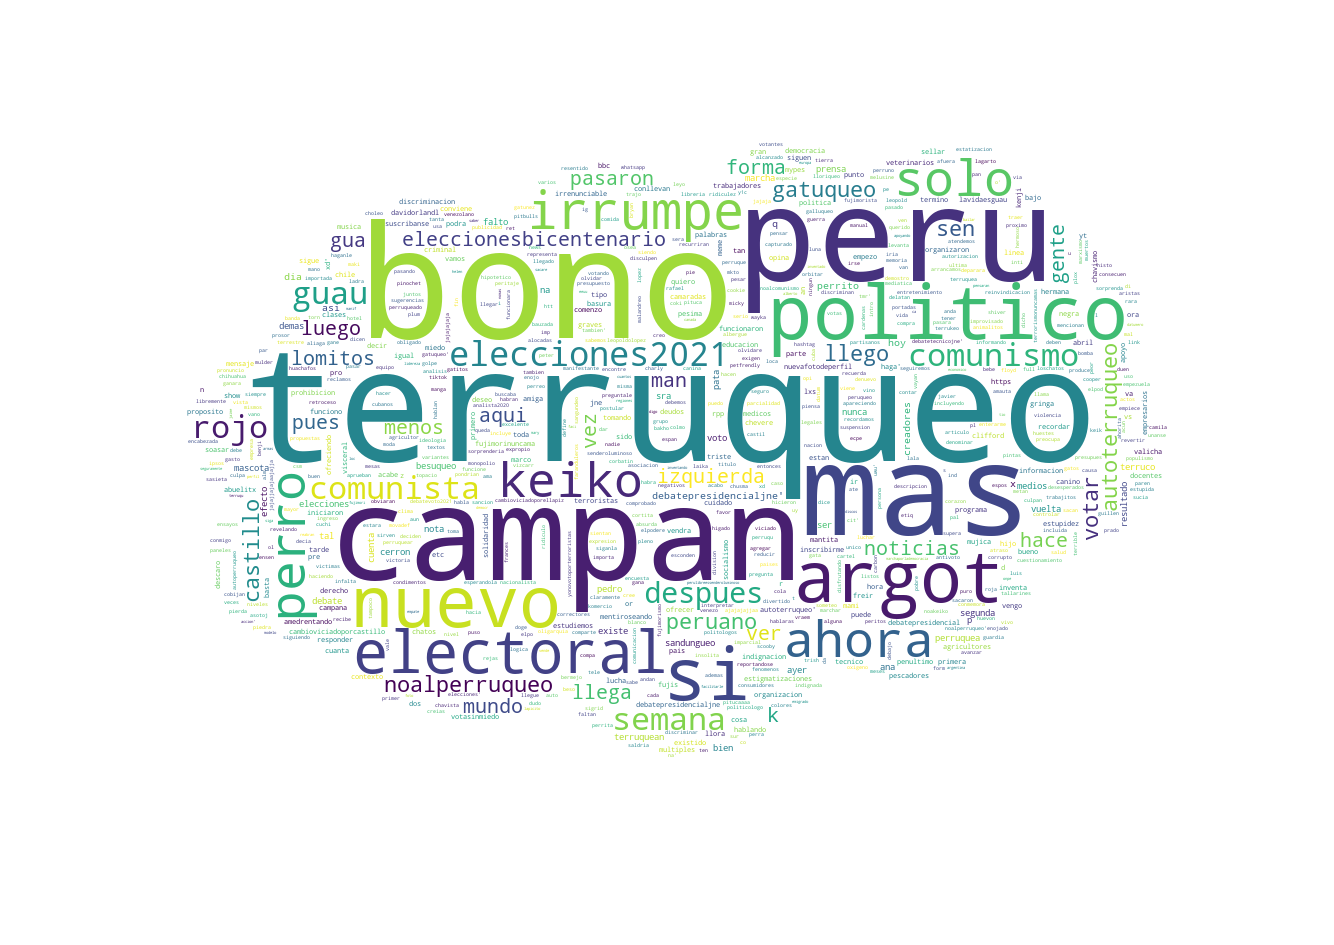

In [ ]:
# Creating wordcloud for all tweets
create_wordcloud(tw_list["text"].values)

# Operaciones Básicas

## Buscar en el texto

Hay muchas formas de examinar el contexto de un texto además de simplemente leerlo. Una vista de concordancia nos muestra cada aparición de una palabra dada, junto con algún contexto. Aquí buscamos la palabra corte en Tradiciones Peruanas ingresando texto seguido de un punto, luego el término concordancia y luego colocando "corte" entre paréntesis:

In [19]:
import nltk
from urllib.request import urlopen

url = "https://www.gutenberg.org/files/21282/21282-8.txt"
raw = urlopen(url).read().decode("ISO-8859-1")
tokens = nltk.word_tokenize(raw[1500:286409], language="spanish")
text = nltk.Text(tokens)

In [20]:
text.concordance("corte")

Displaying 13 of 13 matches:
a su regreso con la resolución de la corte de Madrid , lo obsequiaría diariamen
que sea y depositado en la cárcel de corte , me daréis inmediato conocimiento._
 atado dieron con él en la cárcel de corte , situada en la calle de la Pescader
que habían comprado sus cargos en la corte , a don Juan de Villegas . Durante e
 desperdició coyuntura para hacer su corte a la doncella ; la que al fin , sin 
virrey _Brazo de plata_ instaba a la corte para que se le reemplazase . Sin ver
do el mundo supo que en la cárcel de corte y con gruesas garras de grillos se h
 en los archivos de la excelentísima Corte Suprema , es largo para extractarlo 
 año de los tres sietes nos envió la corte al consejero de Indias don José de A
 su especie tengo listos para que se corte el proceso . Y buenas noches , señor
olo a vivir desterrado de la villa y corte de Madrid . Al siguiente día de la e
sus joyas más valiosas . Seguía a la corte el populacho de la tribu , con cirio
encia de la

Una vez que hayas pasado un rato examinando este texto, espero que tengas un nuevo sentido de la riqueza y diversidad del lenguaje.

Una concordancia nos permite ver palabras en contexto. Por ejemplo, vimos que ocurría corte en contextos como `cargos en la ____` y `que se ____ el proceso`. 

¿Qué otras palabras aparecen en una variedad de contextos similar? Podemos averiguarlo agregando el término similar al nombre del texto en cuestión, luego insertando la palabra relevante entre paréntesis:

In [21]:
text.similar("corte")

iglesia que muerte cárcel mujer guerra trata de el en cabeza virgen
obra audiencia casa letra boca gente puerta palabra


In [22]:
text.similar("libertad")

ella lima oro que en castilla él chile gules plata calumnia distancia
evangelina rodil los duendes de cómo el la


El término `common_contexts` nos permite examinar solo los contextos que comparten dos o más palabras, como corte y libertad. Tenemos que encerrar estas palabras entre corchetes y paréntesis, y separarlas con una coma:

In [23]:
text.common_contexts(["corte", "libertad"])

de_y


Una cosa es detectar automáticamente que una palabra en particular aparece en un texto y mostrar algunas palabras que aparecen en el mismo contexto. Sin embargo, también podemos determinar la ubicación de una palabra en el texto: cuántas palabras desde el principio aparece. Esta información posicional se puede mostrar mediante un gráfico de dispersión. Cada franja representa una instancia de una palabra y cada fila representa el texto completo. 

A continuación vemos algunos patrones llamativos de uso de palabras. Puedes producir este gráfico como se muestra a continuación. Es posible que desee probar con más palabras y diferentes textos. ¿Puedes predecir la dispersión de una palabra antes de verla? Como antes, asegúrese de que las comillas, las comas, los corchetes y los paréntesis sean exactamente correctos.

/home/renato/.virtualenvs/intropy/lib/python3.7/site-packages/nltk/draw/__init__.py:14: UserWarning: nltk.draw package not loaded (please install Tkinter library).
  warnings.warn("nltk.draw package not loaded "


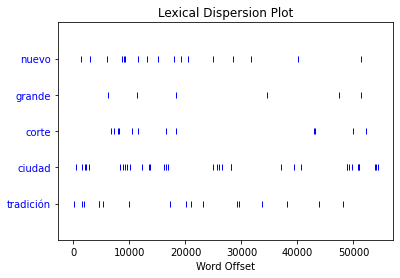

In [24]:
text.dispersion_plot(["nuevo", "grande", "corte", "ciudad", "tradición"])

También puedes generar texto aleatoriamente a partir de un modelo de texto:

In [30]:
text.generate()

TypeError: generate() missing 1 required positional argument: 'words'

## Contando vocabulario 

El hecho más obvio sobre los textos es que difieren en el vocabulario que utilizan. En esta sección veremos cómo usar la computadora para contar las palabras en un texto de diversas formas útiles. 

Comencemos por averiguar la longitud de un texto de principio a fin, en términos de las palabras y los símbolos de puntuación que aparecen. Usamos el término `len` para obtener la longitud de algo, que aplicaremos aquí al libro Tradiciones Peruanas:

In [26]:
len(text)

54507

Así que este libro tiene 54,507 palabras y símbolos de puntuación o "tokens". Un token es el nombre técnico de una secuencia de caracteres, como `peludo`, `suyo` o `:)`, que queremos tratar como grupo. 

Cuando contamos el número de tokens en un texto, digamos, la frase `ser o no ser`, estamos contando apariciones de estas secuencias. Por lo tanto, en nuestra frase de ejemplo hay dos apariciones de `ser` y una de `o` y `no`. Pero solo hay tres elementos de vocabulario distintos en esta frase. 

¿Cuántas palabras distintas contiene el libro Tradiciones Peruanas? Para resolver esto en Python, tenemos que plantear la pregunta de manera ligeramente diferente. El vocabulario de un texto es solo el conjunto de tokens que utiliza, ya que en un conjunto, todos los duplicados se contraen. 

En Python podemos obtener los elementos de vocabulario de `text` con el comando: `set(text)`. Cuando hagas esto, pasarán muchas pantallas de palabras. Ahora intente lo siguiente:

In [27]:
print(sorted(set(text)))

['!', '(', ')', '*', ',', '--', '.', '...', '1', '10', '11', '12', '13', '1378', '14', '15', '1518', '1525', '1533', '1537', '1550', '1555', '1557', '1559', '1560', '1561', '1565', '1573', '16', '1604', '1613', '1614', '1615', '1617', '1619', '1622', '1628', '1629', '1631', '1635', '1639', '1654', '1658', '1665', '1667', '1669', '1670', '1673', '1674', '1676._', '1678', '1681', '1682', '1690', '1694', '17', '1700', '1702', '1707', '171', '1710', '1731', '1734', '1736', '1737', '1738', '1742', '1743', '1744', '1745', '1746', '1752', '1756', '1760', '1761', '1772', '1776', '1777', '1779', '1780', '1781', '1783', '1784', '1785', '1786', '1788', '1790', '1791', '1796', '1799', '18', '1800', '1801', '1804', '1806', '1807', '1808', '1812', '1815', '1817', '1821', '1822', '1824', '1825', '1826', '1834', '1835', '1840', '1845', '1861', '1865', '1874', '1878', '1879', '1880', '1881', '1º', '2', '2.389', '2.800', '20', '20.327', '21', '22', '23', '24', '25', '25.454', '26', '28', '3', '31', '317

In [31]:
len(set(text))

10971

Al envolver `sorted()` alrededor del conjunto de expresiones de Python (text), obtenemos una lista ordenada de elementos de vocabulario, comenzando con varios símbolos de puntuación y continuando con palabras que comienzan con A. Todas las palabras en mayúscula preceden a las minúsculas. 

Descubrimos el tamaño del vocabulario indirectamente, preguntando por el número de elementos en el conjunto, y nuevamente podemos usar `len` para obtener este número. Aunque tiene 54,507 tokens, este libro tiene solo 10,971 palabras distintas, o "tipos de palabras". Un tipo de palabra es la forma o la ortografía de la palabra independientemente de sus ocurrencias específicas en un texto, es decir, la palabra considerada como un elemento único del vocabulario. Nuestro recuento de 11,832 elementos incluirá símbolos de puntuación, por lo que generalmente llamaremos a estos elementos tipos de elementos en lugar de tipos de palabras.

Ahora, calculemos una medida de la riqueza léxica del texto. El siguiente ejemplo nos muestra que el número de palabras distintas es solo el 20% del número total de palabras.

In [32]:
len(set(text)) / len(text)

0.20127690021465133

A continuación, centrémonos en palabras concretas. Podemos contar la frecuencia con la que aparece una palabra en un texto y calcular qué porcentaje del texto ocupa una palabra específica:

In [33]:
print(text.count("ciudad"))
print(100 * text.count("a") / len(text))

35
1.8859962940539747


Es posible que desee repetir dichos cálculos en varios textos, pero es tedioso volver a escribir la fórmula. En su lugar, puede crear su propio nombre para una tarea, como "lexical_diversity" o "percentage", y asociarlo con un bloque de código. Ahora solo tiene que escribir un nombre corto en lugar de una o más líneas completas de código Python, y puede reutilizarlo tantas veces como desee. El siguiente ejemplo muestra cómo definir dos nuevas funciones, lexical_diversity () y porcentaje ():

In [34]:
def lexical_diversity(text):
    return len(set(text)) / len(text)


def percentage(count, total):
    return 100 * count / total

Una vez que Python sepa que `lexical_diversity()` y `percentage()` son los nombres de bloques de código específicos, podemos seguir adelante y usar estas funciones:

In [35]:
print(lexical_diversity(text))

print(percentage(4, 5))

print(percentage(text.count("a"), len(text)))

0.20127690021465133
80.0
1.8859962940539747


Si tienes tiempo, te invito a revisar los tres primeros capítulos del libro del libro [Natural Language Processing with Python – Analyzing Text with the Natural Language Toolkit](https://www.nltk.org/book/).